In [1]:
# Executing this cell will disable all TQDM outputs in stdout.
import os

os.environ["DISABLE_TQDM"] = "True"

# Computing multiple spectrograms with the Core API [^download]

[^download]: This notebook can be downloaded as **{nb-download}`example_multiple_spectrograms_id_core.ipynb`**.

Create an **OSEkit** `AudioDataset` from the files on disk, by directly specifying the requirements in the constructor.

Since we don't know (nor we care about) the files begin timestamps, we'll set the `striptime_format` to `None`, which will assign a default timestamp at which the first valid audio file will be considered to start. Then, each next valid audio file will be considered as starting at the end of the previous one. This default timestamp can be editted thanks to the `first_file_begin` parameter.

An `Instrument` can be provided to the `AudioDataset` for the audio data to be converted in pressure units. This will lead the resulting spectra to be expressed in dB SPL (rather than in dB FS):

We will only use the **folder** in which the files are located: we don't have to dig up to the file level.

In [2]:
from pathlib import Path

audio_folder = Path(r"_static/sample_audio/id")

from osekit.core_api.audio_dataset import AudioDataset
from osekit.core_api.instrument import Instrument
from osekit.utils.audio_utils import Normalization

audio_dataset = AudioDataset.from_folder(
    folder=audio_folder,
    strptime_format=None,
    mode="files",  # Will create one audio data per file. We'll trim them later
    instrument=Instrument(end_to_end_db=165.0),
    sample_rate=24_000,
    normalization=Normalization.DC_REJECT,
)

The `AudioDataset` object contains all the to-be-exported `AudioData`:

In [3]:
print(f"{' AUDIO DATASET ':#^60}")
print(f"{'Begin:':<30}{str(audio_dataset.begin):>30}")
print(f"{'End:':<30}{str(audio_dataset.end):>30}")
print(f"{'Sample rate:':<30}{str(audio_dataset.sample_rate):>30}")
print(f"{'Nb of audio data:':<30}{str(len(audio_dataset.data)):>30}")

###################### AUDIO DATASET #######################
Begin:                                   2020-01-01 00:00:00
End:                                     2020-01-01 00:01:30
Sample rate:                                           24000
Nb of audio data:                                          9


We want to trim these audio data so that they all last `8 s`:

In [4]:
from pandas import Timedelta

for ad in audio_dataset.data:
    ad.end = ad.begin + Timedelta(seconds=8)

Now, we instantiate a `scipy.signal.ShortTimeFFT` FFT object with the required parameters:

In [5]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming

sft = ShortTimeFFT(
    win=hamming(1024),
    hop=128,
    fs=audio_dataset.sample_rate,
)

Create an **OSEkit** `SpectroDataset` from the `AudioDataset` and the `ShortTimeFFT` objects.

We'll also rename these spectro data so that the exported files are named after the original audio file names (that are the IDs).

In [6]:
from osekit.core_api.spectro_dataset import SpectroDataset

spectro_dataset = SpectroDataset.from_audio_dataset(
    audio_dataset=audio_dataset,
    fft=sft,
    v_lim=(0.0, 150.0),  # Boundaries of the spectrograms
    colormap="viridis",  # Default value
)

# RENAMING
for sd in spectro_dataset.data:
    sd.name = next(iter(sd.audio_data.files)).path.stem

We can plot sample `SpectroData` object(s) if we want to glance at the output before computing all spectrograms (notice the 25% overlap as specified):

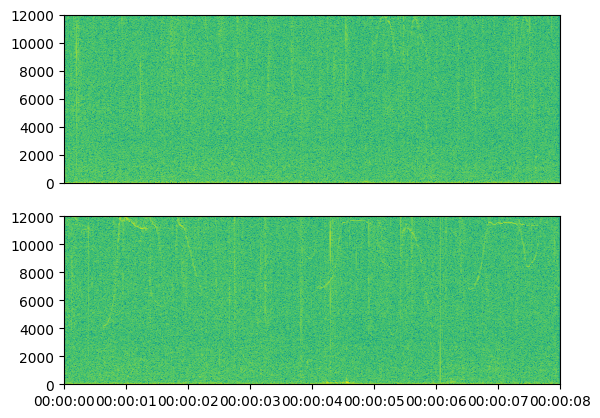

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)

spectro_dataset.data[0].plot(ax=axs[1])
spectro_dataset.data[1].plot(ax=axs[0])
axs[0].get_xaxis().set_visible(False)
plt.show()

We are now ready to export the spectrograms and matrices:

In [ ]:
# Export all spectrograms
spectro_dataset.save_spectrogram(folder=audio_folder / "spectrograms")

# Export all NPZ matrices
spectro_dataset.write(folder=audio_folder / "matrices")

## PSD estimates

We can also export Power Spectral Density estimates using the welch method:

In [ ]:
spectro_dataset.write_welch(folder=audio_folder / "welch")